In [1]:
% matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.chdir("D:\\animal")

In [3]:
# directory where images are stored
DIR = "D:\\animal"

def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    animal_characters = ['C', 'D']
    
    # dictionary where we will store the stats
    stats = []
    
    for animal in animal_characters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, animal)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [4]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")


In [5]:
dataset[["Folder name", "Image count"]]


,Folder name,Image count
Code,,
C1,C1-CAT,8
D1,D1-DOG,10


In [6]:
def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

In [7]:
codes = ["C1", "D1"]
images, labels = load_images(codes)

In [8]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code D1


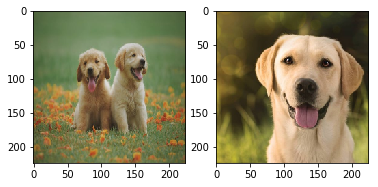

2 random images for code C1


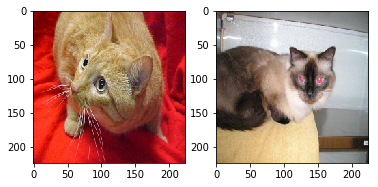

In [9]:
show_random_images(images, labels)


In [10]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [11]:
images, labels = normalise_images(images, labels)


In [12]:
labels

array(['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'D1', 'D1', 'D1',
       'D1', 'D1', 'D1', 'D1', 'D1', 'D1', 'D1'], dtype='<U2')

In [13]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0, random_state=728)
    
    return X_train, y_train

In [14]:
X_train, y_train = shuffle_data(images, labels)


In [15]:
resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat


resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

ResNet50 flattened output has 100352 features


In [17]:
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [18]:
resnet50_pca = create_fit_PCA(resnet50_output)


In [19]:
resnet50_output_pca = resnet50_pca.transform(resnet50_output)


In [20]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [21]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g


In [22]:
print("KMeans (PCA): \n")


KMeans (PCA): 



In [23]:
print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


ResNet50:
Training took 1.0973687171936035 seconds


In [24]:
print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)


ResNet50
Training took 0.05296921730041504 seconds


In [25]:
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)


In [26]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [27]:
k_resnet50_pred = K_resnet50.predict(resnet50_output)


In [28]:
# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)


In [29]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1
C1,2,6
D1,7,3


In [30]:
vgg16_cluster_code = ["C1","D1"]
vgg16_cluster_code_pca = ["C1","D1"]

In [31]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_resnet50_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_resnet50_pred]

In [32]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 0.27554180   |   Accuracy: 0.27554180
KMeans VGG16 (PCA) 
	F1 Score: 0.27554180   |   Accuracy: 0.27554180


In [33]:
pred=print_scores(y_train, vgg16_pred_codes)

In [34]:
pred

'\n\tF1 Score: 0.27554180   |   Accuracy: 0.27554180'